# Apoyo a la solución del ejercicio 1 de ETL
___

Lo primero que necesitamos saber es como obtener lo que se pide, en este caso nos vamos a centrar en el primer punto de hombres y mujeres activos/as al año. Para ello vamos a contar las personas activas en cada año lo cual necesitamos una lista con los años de vida de la empresa y la información de cuantas persona activas había en los respectivos años.

#### 1. Importamos librerías

In [ ]:
import pandas as pd
import seaborn as sns

#### 2. Cargamos los datos

En este caso vamos a poder encontrar los datos de sexo y año de contratación y extinción de contrato en los csv's datos_personales y datos_laborales respectivamente

In [ ]:
path = "./datos/"

In [ ]:
df_pers = pd.read_csv(path + "datos_personales.csv")
df_lab = pd.read_csv(path + "datos_laborales.csv")

#### 3. Nos quedamos solo con lo importante

In [ ]:
df_lab = df_lab[["EmpID", "DateofHire", "DateofTermination"]]
df_lab.head(3)

,EmpID,DateofHire,DateofTermination
0,10026,7/5/2011,NaN
1,10084,3/30/2015,6/16/2016
2,10196,7/5/2011,9/24/2012


In [ ]:
df_pers = df_pers[["EmpID", "Sex"]]
df_pers.head(3)

,EmpID,Sex
0,10026,M
1,10084,M
2,10196,F


Ahora que tenemos solo lo que vamos a necesitar vamos a unir todo en un dataframe

In [ ]:
df_tot = pd.merge(df_lab, df_pers, on="EmpID", how="inner")
df_tot.head(3)

,EmpID,DateofHire,DateofTermination,Sex
0,10026,7/5/2011,NaN,M
1,10084,3/30/2015,6/16/2016,M
2,10196,7/5/2011,9/24/2012,F


#### 4. Extraemos la información del año

In [ ]:
df_tot["year_hire"] = df_tot["DateofHire"].str.split("/").str[-1]
df_tot["year_term"] = df_tot["DateofTermination"].str.split("/").str[-1]

# Además cambio la columna a tipo entero con el fin de manejar números.
df_tot["year_hire"] = df_tot["year_hire"].astype(int)

# Dado que en year_term tenemos NaN los rellenamos con el año máximo de contratación
# TODO: De hacer ese fillna se puede derivar un error el cual no vamos a tener en
#    consideración para facilitar el ejercicio pero hay que controlar las suposiciones que 
#    se realizan y porque se realizan.
df_tot["year_term"].fillna(df_tot["year_hire"].max(), inplace=True)
df_tot["year_term"] = df_tot["year_term"].astype(int)

df_tot.head(3)

,EmpID,DateofHire,DateofTermination,Sex,year_hire,year_term
0,10026,7/5/2011,NaN,M,2011,2018
1,10084,3/30/2015,6/16/2016,M,2015,2016
2,10196,7/5/2011,9/24/2012,F,2011,2012


In [ ]:
# Nos vamos a quedar de nuevo solo con las columnas que nos interesan
df_tot = df_tot[["EmpID", "year_hire", "year_term", "Sex"]]
df_tot.head(3)

,EmpID,year_hire,year_term,Sex
0,10026,2011,2018,M
1,10084,2015,2016,M
2,10196,2011,2012,F


#### 5. Obtenemos el rango de años

In [ ]:
# Sobre este rango de años vamos a calcular la evolución.
# TODO: Aquí hay un posible error que tampoco vamos a considerar, como en 
#    la celda anterior. ¿Sabríais cual es?
hiring_years = df_tot["year_hire"].unique()
hiring_years

array([2011, 2015, 2008, 2012, 2014, 2013, 2009, 2016, 2010, 2018, 2017,
       2007, 2006])

#### 6. Contar personas

Esto es solo una manera, puede haber muchas otras maneras no consideréis esto como la verdad absoluta.

El proceso que busco es contar mujeres y hombres por año que estén contratados. Esto lo vamos a realizar mediante máscaras sobre un dataframe donde consideramos que una persona está activa en un año dado siempre y cuando **su fecha de contratación sea menor o igual que la fecha en curso y además la fecha de fin de contrato sea mayor que la fecha en curso**.

In [ ]:
igualdad_info = dict()
for year in hiring_years:
    igualdad_info[year] = df_tot[(df_tot["year_hire"] <= year) & (df_tot["year_term"] > year)] \
                            .groupby(["Sex"])["EmpID"].count().to_dict()
igualdad_info

{2011: {'F': 64, 'M ': 37},
 2015: {'F': 126, 'M ': 103},
 2008: {'F': 3, 'M ': 3},
 2012: {'F': 82, 'M ': 56},
 2014: {'F': 121, 'M ': 95},
 2013: {'F': 98, 'M ': 71},
 2009: {'F': 8, 'M ': 5},
 2016: {'F': 124, 'M ': 97},
 2010: {'F': 13, 'M ': 8},
 2018: {},
 2017: {'F': 122, 'M ': 97},
 2007: {'M ': 3},
 2006: {'M ': 1}}

Ahora vamos a darle un formato de dataframe

In [ ]:
igualdad = pd.DataFrame(igualdad_info).unstack()  # Mediante esto obtendríamos una Serie
igualdad.index.set_names(["year", "sex"], inplace=True)  # Con esto renombramos el multi-indice
igualdad = igualdad.reset_index()  # Con esto estaríamos convirtiendo a DataFrame
igualdad.rename(columns={0: "total"}, inplace=True)  # Con esto estamos renombrando la columna de total de personas
igualdad.fillna(0, inplace=True)  # Con esto estamos rellenando los posible vacíos

In [ ]:
igualdad.head(3)

,year,sex,total
0,2011,F,64.0
1,2011,M,37.0
2,2015,F,126.0
3,2015,M,103.0
4,2008,F,3.0


Finalmente para añadir la información percentual vamos a agrupar unir y dividir

In [ ]:
df_grp = igualdad.groupby("year", as_index=False)["total"].sum()
df_grp.head(3)

,year,total
0,2006,1.0
1,2007,3.0
2,2008,6.0


In [ ]:
df_ig = pd.merge(igualdad, df_grp, on="year", how="inner", suffixes=("_sex", "_year"))
df_ig.head(3)

,year,sex,total_sex,total_year
0,2011,F,64.0,101.0
1,2011,M,37.0,101.0
2,2015,F,126.0,229.0


In [ ]:
df_ig["percent"] = (100 * df_ig["total_sex"] / df_ig["total_year"]).round(2)
df_ig.head(3)

,year,sex,total_sex,total_year,percent
0,2011,F,64.0,101.0,63.37
1,2011,M,37.0,101.0,36.63
2,2015,F,126.0,229.0,55.02


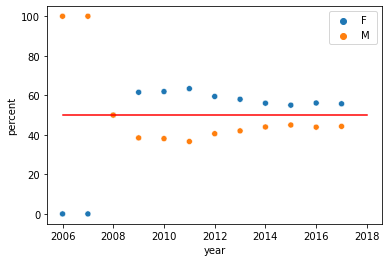

In [ ]:
sns.scatterplot(data=df_ig, x="year", y="percent", hue="sex")
sns.lineplot(x=hiring_years, y=[50] * len(hiring_years), color="red");

---

Una vez que sabemos el proceso con el cual obtenemos el resultado llega el momento de escribirlo en una API que se pueda consumir.